In [1]:
import numpy as np 
import pandas as pd
import matplotlib.pyplot as plt 
from catboost import CatBoostRegressor
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import StratifiedKFold

In [7]:
%pylab inline
plt.style.use("bmh")

Populating the interactive namespace from numpy and matplotlib


In [62]:
df = pd.read_csv('sc2021_train_deals.csv', parse_dates=["month", "date"])

groups = ['material_code', 'country', 'region', 'manager_code', 'company_code']
lvls = ['material_lvl1_name', 'material_lvl2_name', 'material_lvl3_name']

In [63]:
values_ts = df.groupby(groups + lvls + ['month'])['volume'].sum().unstack(fill_value = 0)
values_ts = np.log(values_ts + 1)

lvl_ts = df.groupby(lvls + ['month'])['volume'].mean().unstack(fill_value = 0)
lvl_groups_ts = df.groupby(groups + lvls + ['month'])['volume'].sum().unstack(fill_value = 0)
new_ts = pd.DataFrame([], index = lvl_groups_ts.index)
lvl_ts = new_ts.join(lvl_ts, on = lvls).reset_index(level = lvls).drop(columns = lvls)
lvl_ts = np.log(lvl_ts + 1)

diff_ts = pd.DataFrame([], columns=values_ts.columns[1:])
rb = values_ts.iloc[:, 1:] 
lb = values_ts.iloc[:, :-1] 
diff_ts[values_ts.columns[1:]] = rb.values - lb.values

series = {'vol': values_ts, 'lvl_means': lvl_ts, "diff": diff_ts}

In [64]:
def features(ts: dict, month: pd.Timestamp, past_month_num: int = 6) -> pd.DataFrame:
    
    mode = 'vol'
    start_period = month - pd.offsets.MonthBegin(past_month_num)
    end_period = month - pd.offsets.MonthBegin(1)
    
    features = pd.DataFrame([], index=ts[mode].index)

    
    features[[f"vol_{i}" for i in np.arange(past_month_num, 0, -1)]] = ts[mode].loc[:,start_period:end_period].copy()
    features[[f"diff_{i}" for i in np.arange(past_month_num, 0, -1)]] = ts[mode].loc[:,start_period:end_period].copy()
    features["lvl_diff"] = ts[mode].loc[:, end_period] - ts["lvl_means"].loc[:, end_period]
    
    features["zero_counts"] = (ts[mode].loc[:,:end_period] == 0).astype(int).sum(axis=1).values
    features["plato_counts"] = (ts["diff"].loc[:,:end_period] == 0).astype(int).sum(axis=1).values
    features["mean_diff"] = ts["diff"].loc[:, :end_period].abs().mean(axis=1).values
    features["max_diff"] = ts["diff"].loc[:, :end_period].abs().max(axis=1).values
    
    rolling = ts[mode].loc[:, :end_period].rolling(3, axis=1, min_periods=1)
    features = features.join(rolling.mean().iloc[:, -1].rename("3_month_mean"))
    features = features.join(rolling.max().iloc[:, -1].rename("3_month_max"))
    
    features["month"] = month
    features["month_number"] = month.month
    features["days_in_month"] = month.days_in_month
    
    return features

In [65]:
month_range = pd.date_range("2018-07-01", "2020-07-01", freq="MS")
val_month = pd.Timestamp("2020-07-01")

In [66]:
train = []
for month in month_range:
    train_ = features(series, month, 6)
    train_["target"] = values_ts[month]
    train.append(train_.reset_index())
train = pd.concat(train, ignore_index=True)

Text(0.5, 1.0, 'target distribution')

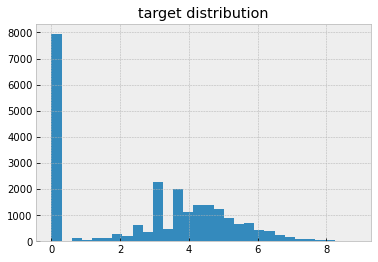

In [67]:
_ = train.target.hist(bins=30)
plt.title("target distribution")

In [55]:
CAT_COLS = ["material_code", "country", "region", "company_code", "manager_code", "month_number", "days_in_month"]
CUS_COLS = ["zero_counts", "mean_diff", "plato_counts", "lvl_diff", "3_month_mean", "3_month_max", "max_diff"]
FEATURES =  [f"vol_{i}" for i in range(4, 0,-1)] + [f"diff_{i}" for i in np.arange(4, 0, -1)] + CAT_COLS + CUS_COLS
TARGET = "target"

trainset = train[train.month < val_month]
valset = train[train.month == val_month]

In [60]:
model = CatBoostRegressor(iterations=1000,
                          loss_function="Tweedie:variance_power=1.1",
                          eval_metric="RMSE",
                          depth=6,
                          l2_leaf_reg = 3,
                          cat_features=CAT_COLS,
                          random_state=22,
                          verbose=100, 
                          early_stopping_rounds = 100,
                          use_best_model=True)

In [61]:
model.fit(trainset[FEATURES], trainset[TARGET], eval_set=(valset[FEATURES], valset[TARGET]))

0:	learn: 3.5211493	test: 3.7599657	best: 3.7599657 (0)	total: 99.2ms	remaining: 1m 39s
100:	learn: 2.7071918	test: 2.8752402	best: 2.8752402 (100)	total: 8.03s	remaining: 1m 11s
200:	learn: 2.6843737	test: 2.8370276	best: 2.8370276 (200)	total: 15.5s	remaining: 1m 1s
300:	learn: 2.6812040	test: 2.8335525	best: 2.8335217 (299)	total: 23.7s	remaining: 55.1s
400:	learn: 2.6800062	test: 2.8317052	best: 2.8313731 (394)	total: 32.1s	remaining: 47.9s
500:	learn: 2.6784691	test: 2.8282488	best: 2.8282488 (500)	total: 40.7s	remaining: 40.5s
600:	learn: 2.6764449	test: 2.8253853	best: 2.8253853 (600)	total: 48.6s	remaining: 32.2s
700:	learn: 2.6758714	test: 2.8249229	best: 2.8246840 (697)	total: 56.3s	remaining: 24s
800:	learn: 2.6744602	test: 2.8226312	best: 2.8225680 (798)	total: 1m 4s	remaining: 16s
900:	learn: 2.6731069	test: 2.8215897	best: 2.8214331 (895)	total: 1m 12s	remaining: 7.96s
999:	learn: 2.6726054	test: 2.8222607	best: 2.8211937 (923)	total: 1m 19s	remaining: 0us

bestTest = 2.8

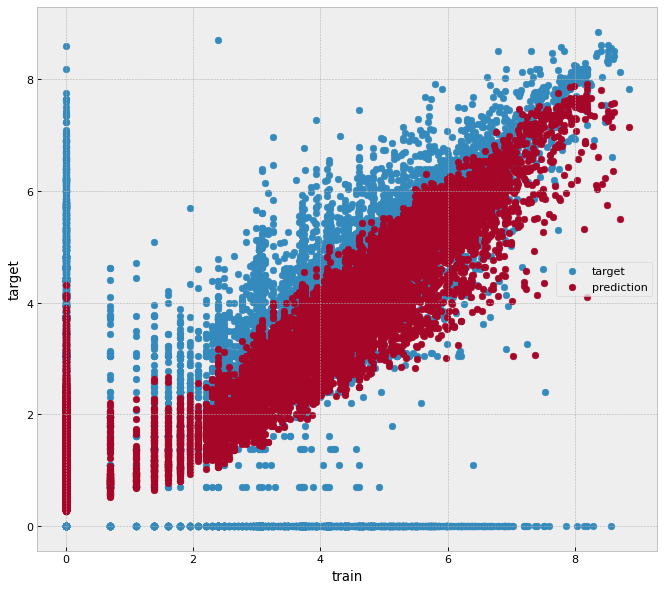

In [50]:
plt.figure(figsize=(10, 9), dpi=80)

x = trainset["vol_1"]
y = trainset["target"]
pred = model.predict(trainset[FEATURES])

plt.scatter(x,y, label="target")
plt.scatter(x,pred, label="prediction")
plt.xlabel("train")
plt.ylabel("target")
plt.legend()

Text(0.5, 1.0, 'predictions distribution')

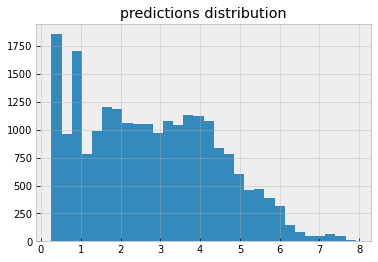

In [53]:
df_ = pd.DataFrame()
df_["pred"] = model.predict(trainset[FEATURES])
df_["pred"].hist(bins=30)
plt.title("predictions distribution")

In [29]:
model.save_model("model.cbm")